# **<h1 align="center"><font size="10">Computer Vision Project - Indonesian Food Image Classification</font></h1>**
**<p align="center"><font size="3">by: Reygen Win</font></h1>**

---


Image Source: [Mendley Data](https://data.mendeley.com/datasets/vtjd68bmwt/1)

## 1. Import Package

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image

import pandas as pd
import matplotlib.pyplot as plt

from timeit import default_timer as timer
from tqdm.auto import tqdm

from typing import List, Dict

import os
import requests
import zipfile
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 2. Load Dataset

### 2.1 Download Dataset

In [ ]:
# Setup path to data
data_path = Path("data/")
image_paths = data_path / "indonesian_food_image"

# If image folder doesn't exist, create the directory and download the dataset
if image_paths.is_dir():
    print(f"{image_paths} directory exists.")
else:
    print(f"Did not find {image_paths} directory, creating one...")
    image_paths.mkdir(parents=True, exist_ok=True)

    with open(data_path / "data.zip", "wb") as f:
        request = requests.get("https://github.com/reygen-win/Machine-Learning/raw/refs/heads/main/Classification/4_Indonesia%20Food%20Image%20Classification/indonesia_food_image.zip")
        print("Downloading Indonesian food image...")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "data.zip", "r") as zip_ref:
        print("Unzipping Indonesian food image...")
        zip_ref.extractall(image_paths)

Did not find data/indonesian_food_image directory, creating one...
Unzipping Indonesian food image...


### 2.2 Check the Number of Image in Each Labels

In [ ]:
for dirpath, dirnames, filenames in os.walk(image_paths):
    # Only print the dirpath with images
    if filenames:
        print(f"There are {len(filenames)} images in '{dirpath}'.")

There are 123 images in 'data/indonesian_food_image/test/pempek'.
There are 130 images in 'data/indonesian_food_image/test/bakso'.
There are 97 images in 'data/indonesian_food_image/test/bebek_betutu'.
There are 94 images in 'data/indonesian_food_image/test/rendang'.
There are 82 images in 'data/indonesian_food_image/test/gudeg'.
There are 141 images in 'data/indonesian_food_image/test/soto'.
There are 113 images in 'data/indonesian_food_image/test/gado_gado'.
There are 154 images in 'data/indonesian_food_image/test/sate'.
There are 104 images in 'data/indonesian_food_image/test/rawon'.
There are 155 images in 'data/indonesian_food_image/test/nasi_goreng'.
There are 286 images in 'data/indonesian_food_image/train/pempek'.
There are 315 images in 'data/indonesian_food_image/train/bakso'.
There are 238 images in 'data/indonesian_food_image/train/bebek_betutu'.
There are 237 images in 'data/indonesian_food_image/train/rendang'.
There are 213 images in 'data/indonesian_food_image/train/gud

In [ ]:
train_dir = image_paths / "train"
test_dir = image_paths / "test"

train_dir, test_dir

(PosixPath('data/indonesian_food_image/train'),
 PosixPath('data/indonesian_food_image/test'))

Random image path: data/indonesian_food_image/train/soto/soto_385.jpg
Image class: soto
Image height: 162
Image width: 310


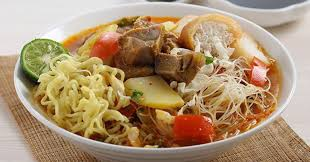

In [ ]:
# Visualize random image
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_paths.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

## 3. Model Building

### 3.1 ViT B-16 Model

We will use pre-trained [ViT-B16 model](https://docs.pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16)

In [ ]:
# Create Weight and Transform of ViT-b16
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # Get the best available weights
vit_transforms = vit_weights.transforms()
vit_weights, vit_transforms

(ViT_B_16_Weights.IMAGENET1K_V1,
 ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BILINEAR
 ))

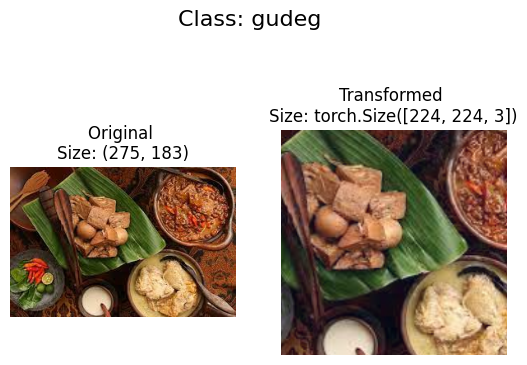

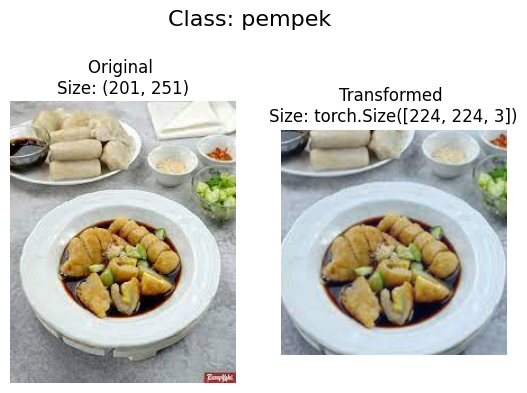

In [ ]:
# Try to plot transformed image:
torch.manual_seed(42)

image_path_list = list(image_paths.glob("*/*/*.jpg"))

random_image_paths = random.sample(image_path_list, k=2)
for image_path in random_image_paths:
    with Image.open(image_path) as f:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(f)
        ax[0].set_title(f"Original \nSize: {f.size}")
        ax[0].axis("off")

        # Transform and plot image
        # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
        transformed_image = vit_transforms(f).permute(1, 2, 0)

        # Normalize the transformed image data for plotting
        # We'll scale it to the 0-1 range for plotting
        transformed_image = (transformed_image - transformed_image.min()) / (transformed_image.max() - transformed_image.min())

        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
        ax[1].axis("off")

        fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

In [ ]:
# Create train and test datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=vit_transforms,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=vit_transforms,
                                 target_transform=None)
print(f"Train data:\n{train_data}")
print(f"Test data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 2866
    Root location: data/indonesian_food_image/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 1193
    Root location: data/indonesian_food_image/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )


In [ ]:
class_names = train_data.classes
class_names

['bakso',
 'bebek_betutu',
 'gado_gado',
 'gudeg',
 'nasi_goreng',
 'pempek',
 'rawon',
 'rendang',
 'sate',
 'soto']

In [ ]:
class_dict = train_data.class_to_idx
class_dict

{'bakso': 0,
 'bebek_betutu': 1,
 'gado_gado': 2,
 'gudeg': 3,
 'nasi_goreng': 4,
 'pempek': 5,
 'rawon': 6,
 'rendang': 7,
 'sate': 8,
 'soto': 9}

In [ ]:
# Create DataLoader
BATCH_SIZE = 32;
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

print(f"Train DataLoader: {len(train_dataloader)} batches of batch size {BATCH_SIZE}")
print(f"Test DataLoader: {len(test_dataloader)} batches of batch size {BATCH_SIZE}")

Train DataLoader: 90 batches of batch size 32
Test DataLoader: 38 batches of batch size 32


In [ ]:
vit_model = torchvision.models.vit_b_16(weights=vit_weights)
vit_model

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:02<00:00, 147MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
# Freeze all layers in the model, and modify the classifier
torch.manual_seed(42)

for param in vit_model.parameters():
    param.requires_grad = False

vit_model.heads = nn.Sequential(
    nn.Linear(in_features=768,  # Keep it the same as the original model
              out_features=len(class_names) # Modify to our the number of our class_names
              ))

vit_model.heads

Sequential(
  (0): Linear(in_features=768, out_features=10, bias=True)
)

In [ ]:
# Set the loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=vit_model.parameters(),
                             lr=0.001)

In [ ]:
# Setup the accuracy function
def accuracy_fn(y_pred: torch.Tensor,
                y_true: torch.Tensor) -> float:
    correct = torch.eq(y_pred, y_true).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
# Train step function
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device,
               is_print: bool = False
               ):
    # 1. Set up train loss and send model to device
    train_loss = 0
    train_acc = 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # 2. Send data to device
        X = X.to(device)
        y = y.to(device)

        # 3. Forward pass
        y_pred_logits = model(X)
        y_pred = torch.argmax(y_pred_logits, dim=1)

        # 4. Calculate the loss
        loss = loss_fn(y_pred_logits, y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred, y)

        # 5. Optimizer zero grad
        optimizer.zero_grad()

        # 6. Loss backward
        loss.backward()

        # 7. Optimizer step
        optimizer.step()

    # 8. Calculate the averaged loss
    train_loss /= len(data_loader)  # Number of batch
    train_acc /= len(data_loader)
    if is_print:
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

    return train_loss, train_acc

In [ ]:
# Test step function
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device,
              is_print: bool = False
              ):
    # 1. Set up train loss and send model to device
    test_loss = 0
    test_acc = 0
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            # 2. Send data to device
            X = X.to(device)
            y = y.to(device)

            # 3. Forward pass
            y_pred_logits = model(X)
            y_pred = torch.argmax(y_pred_logits, dim=1)

            # 4. Calculate the loss and accuracy
            test_loss += loss_fn(y_pred_logits, y)
            test_acc += accuracy_fn(y_pred, y)

    # 5. Calculate the averaged loss
    test_loss = test_loss / len(data_loader)  # Number of batch
    test_acc = test_acc / len(data_loader)

    if is_print:
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")

    return test_loss, test_acc

In [ ]:
# Overall training function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          accuracy_fn,
          optimizer: torch.optim.Optimizer,
          epochs: int = 10,
          device: torch.device = device):
    # 1. Create empty result dict
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 2. Loop train_step and test_step for a number of epochs
    for epoch in tqdm(range(epochs)):
        # Training step
        train_loss, train_acc = train_step(model,
                                           train_dataloader,
                                           loss_fn,
                                           accuracy_fn,
                                           optimizer,
                                           device)

        # Test step
        test_loss, test_acc = test_step(model,
                                        test_dataloader,
                                        loss_fn,
                                        accuracy_fn,
                                        device)

        # 3. Print out result each epoch
        print(f"Epoch: {epoch} | train_loss: {train_loss:.5f} | train_acc: {train_acc:.2f}% | test_loss: {test_loss:.5f} | test_acc: {test_acc:.2f}%")

        # 4. Update result to dict
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 5. Return the results
    return results

In [ ]:
# Start the training
torch.manual_seed(42)
NUM_EPOCHS = 20

start_time = timer()
vit_model_results = train(model=vit_model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        loss_fn=loss_fn,
                        accuracy_fn=accuracy_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        device=device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 0.73558 | train_acc: 79.90% | test_loss: 0.65948 | test_acc: 80.62%
Epoch: 1 | train_loss: 0.56648 | train_acc: 84.89% | test_loss: 0.56005 | test_acc: 83.31%
Epoch: 2 | train_loss: 0.47644 | train_acc: 87.11% | test_loss: 0.50572 | test_acc: 84.40%
Epoch: 3 | train_loss: 0.41580 | train_acc: 88.91% | test_loss: 0.47102 | test_acc: 86.22%
Epoch: 4 | train_loss: 0.36956 | train_acc: 90.11% | test_loss: 0.44839 | test_acc: 86.27%
Epoch: 5 | train_loss: 0.33921 | train_acc: 91.53% | test_loss: 0.42888 | test_acc: 87.13%
Epoch: 6 | train_loss: 0.30631 | train_acc: 92.31% | test_loss: 0.41248 | test_acc: 87.33%
Epoch: 7 | train_loss: 0.27897 | train_acc: 93.43% | test_loss: 0.41002 | test_acc: 87.12%
Epoch: 8 | train_loss: 0.25591 | train_acc: 94.42% | test_loss: 0.39426 | test_acc: 87.45%
Epoch: 9 | train_loss: 0.23917 | train_acc: 94.74% | test_loss: 0.38311 | test_acc: 88.19%
Epoch: 10 | train_loss: 0.22213 | train_acc: 95.03% | test_loss: 0.37819 | test_acc: 88.28

In [ ]:
# Plot loss and accuracy curves
def plot_loss_acc(results: Dict[str, List[float]]):
    # 1. Get the loss and acc from results dict
    train_loss = results["train_loss"]
    train_acc = results["train_acc"]

    test_loss = results["test_loss"]
    test_acc = results["test_acc"]

    epochs = range(len(train_loss))

    # 2. Plot
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, c='b', label="Training Loss")
    plt.plot(epochs, test_loss, c='r', label="Test Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, c='b', label="Training Acc")
    plt.plot(epochs, test_acc, c='r', label="Test Acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    plt.show();

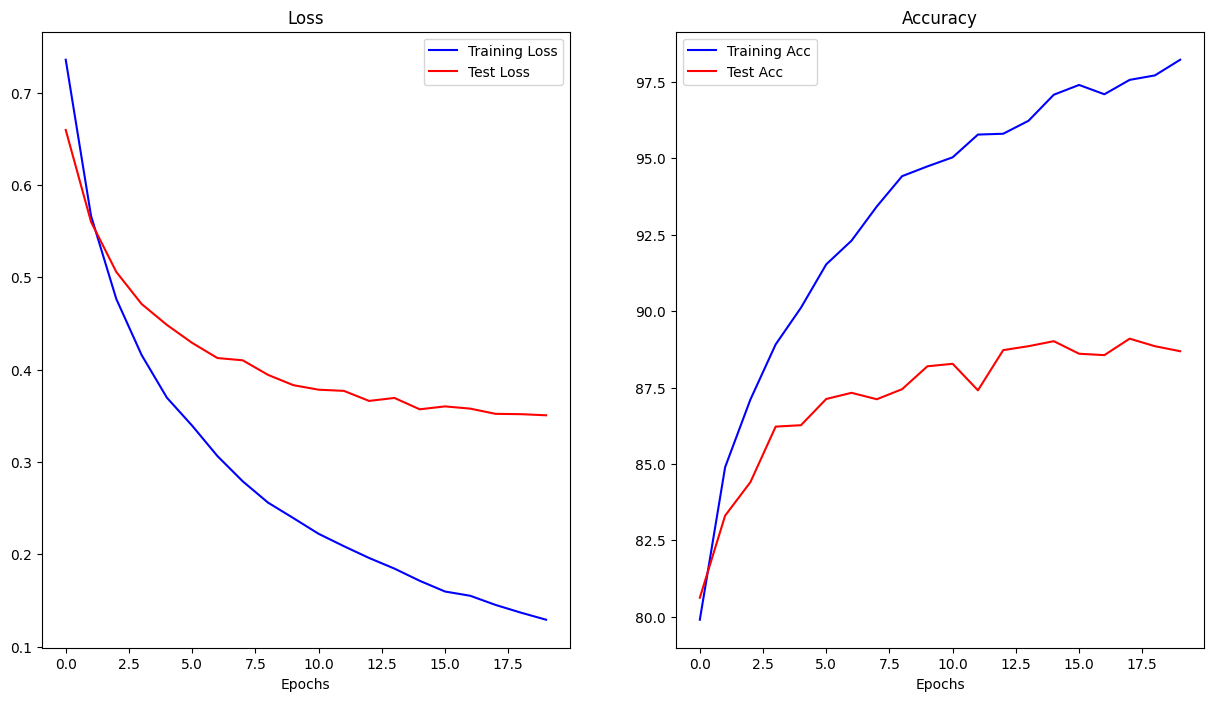

In [ ]:
plot_loss_acc(vit_model_results)

The model seems to overfit to the training set. Let's try a simpler model, like EfficientNetB2.

### 3.2 EfficientNet B2 Model

We will use pre-trained [EfficientNetB2](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html)

In [ ]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()
effnetb2_weights, effnetb2_transforms

(EfficientNet_B2_Weights.IMAGENET1K_V1,
 ImageClassification(
     crop_size=[288]
     resize_size=[288]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ))

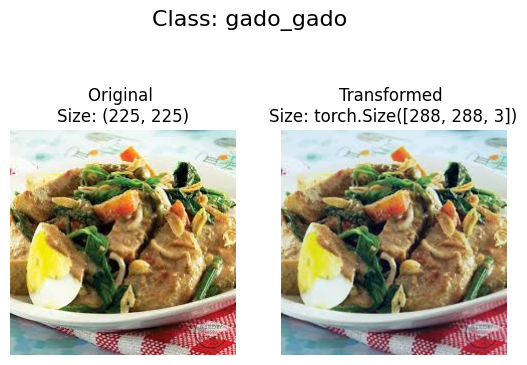

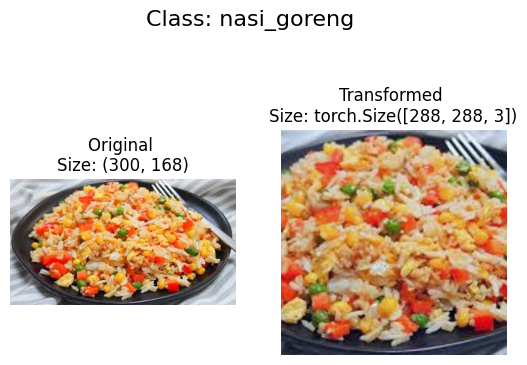

In [ ]:
# Try to plot transformed image:
torch.manual_seed(42)

image_path_list = list(image_paths.glob("*/*/*.jpg"))

random_image_paths = random.sample(image_path_list, k=2)
for image_path in random_image_paths:
    with Image.open(image_path) as f:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(f)
        ax[0].set_title(f"Original \nSize: {f.size}")
        ax[0].axis("off")

        # Transform and plot image
        # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
        transformed_image = effnetb2_transforms(f).permute(1, 2, 0)

        # Normalize the transformed image data for plotting
        # We'll scale it to the 0-1 range for plotting
        transformed_image = (transformed_image - transformed_image.min()) / (transformed_image.max() - transformed_image.min())

        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
        ax[1].axis("off")

        fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

In [ ]:
effnetb2_train_data = datasets.ImageFolder(root=train_dir,
                                  transform=vit_transforms,
                                  target_transform=None)

effnetb2_test_data = datasets.ImageFolder(root=test_dir,
                                 transform=vit_transforms,
                                 target_transform=None)
print(f"Train data:\n{effnetb2_train_data}")
print(f"Test data:\n{effnetb2_test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 2866
    Root location: data/indonesian_food_image/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 1193
    Root location: data/indonesian_food_image/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )


In [ ]:
effnetb2_train_dataloader = DataLoader(effnetb2_train_data,
                                       batch_size = BATCH_SIZE,
                                       shuffle=True,
                                       num_workers=NUM_WORKERS)

effnetb2_test_dataloader = DataLoader(effnetb2_test_data,
                                      batch_size=BATCH_SIZE,
                                      shuffle=False,
                                      num_workers=NUM_WORKERS)

print(f"Train DataLoader: {len(train_dataloader)} batches of batch size {BATCH_SIZE}")
print(f"Test DataLoader: {len(test_dataloader)} batches of batch size {BATCH_SIZE}")

Train DataLoader: 90 batches of batch size 32
Test DataLoader: 38 batches of batch size 32


In [ ]:
# Build the model
effnetb2_model = torchvision.models.efficientnet_b2(weights=effnetb2_weights)
effnetb2_model

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 174MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# Freeze all layers in the model, and modify the classifier
torch.manual_seed(42)

for param in effnetb2_model.parameters():
    param.requires_grad = False

effnetb2_model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),    # Keep it the same as original model
    nn.Linear(in_features=1408,  # Keep it the same as the original model
              out_features=len(class_names), # Modify to our the number of our class_names
              bias=True # Keep it the same as original model
              ))

effnetb2_model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=10, bias=True)
)

In [ ]:
# Setup loss function and optimizer
effnetb2_loss_fn = torch.nn.CrossEntropyLoss()

effnetb2_optim = torch.optim.Adam(params=effnetb2_model.parameters(),
                                  lr=0.001)

effnetb2_loss_fn, effnetb2_optim

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     decoupled_weight_decay: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [ ]:
# Start the training
torch.manual_seed(42)
NUM_EPOCHS = 15

start_time = timer()
effnetb2_results = train(model=effnetb2_model,
                        train_dataloader=effnetb2_train_dataloader,
                        test_dataloader=effnetb2_test_dataloader,
                        loss_fn=effnetb2_loss_fn,
                        accuracy_fn=accuracy_fn,
                        optimizer=effnetb2_optim,
                        epochs=NUM_EPOCHS,
                        device=device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 1.85899 | train_acc: 43.37% | test_loss: 1.45308 | test_acc: 62.86%
Epoch: 1 | train_loss: 1.22754 | train_acc: 70.00% | test_loss: 1.13034 | test_acc: 69.85%
Epoch: 2 | train_loss: 0.94749 | train_acc: 76.84% | test_loss: 0.99759 | test_acc: 72.31%
Epoch: 3 | train_loss: 0.79092 | train_acc: 80.46% | test_loss: 0.92465 | test_acc: 71.74%
Epoch: 4 | train_loss: 0.68601 | train_acc: 83.29% | test_loss: 0.88088 | test_acc: 73.38%
Epoch: 5 | train_loss: 0.60796 | train_acc: 85.27% | test_loss: 0.85643 | test_acc: 72.56%
Epoch: 6 | train_loss: 0.54238 | train_acc: 87.54% | test_loss: 0.83522 | test_acc: 73.96%
Epoch: 7 | train_loss: 0.49061 | train_acc: 88.90% | test_loss: 0.82970 | test_acc: 72.51%
Epoch: 8 | train_loss: 0.44332 | train_acc: 90.31% | test_loss: 0.82043 | test_acc: 73.01%
Epoch: 9 | train_loss: 0.40590 | train_acc: 92.13% | test_loss: 0.81728 | test_acc: 73.01%
Epoch: 10 | train_loss: 0.37138 | train_acc: 93.38% | test_loss: 0.81228 | test_acc: 73.59

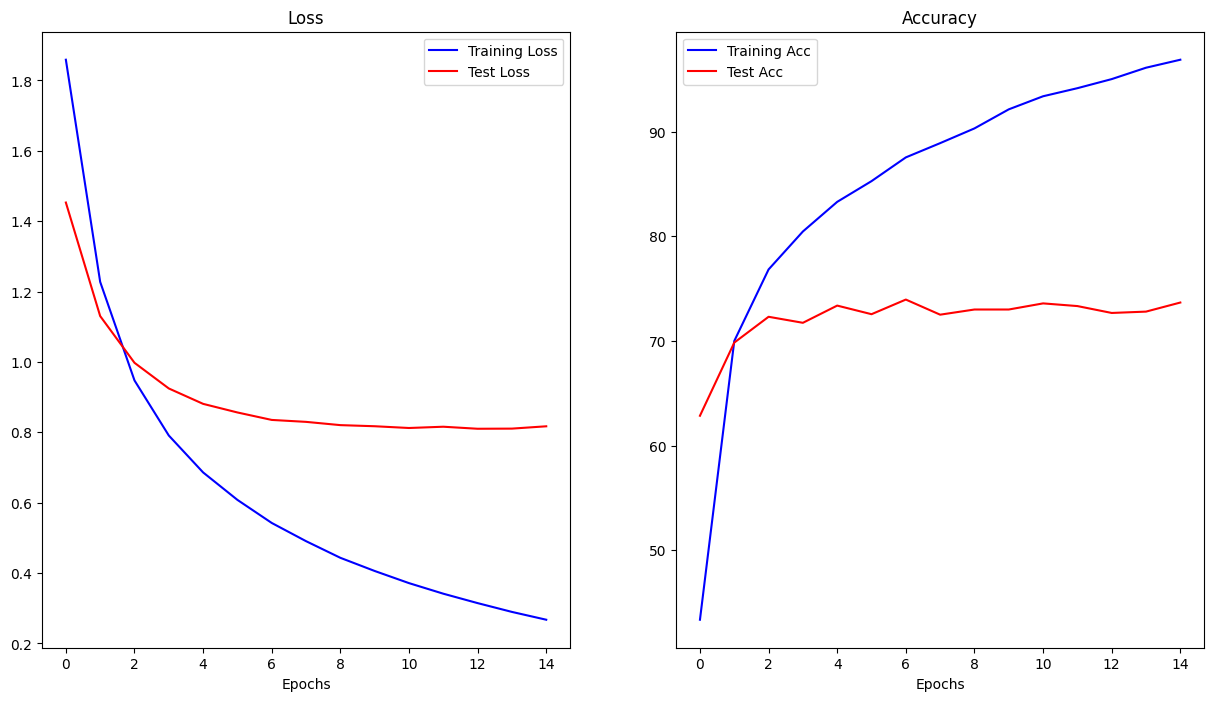

In [ ]:
plot_loss_acc(effnetb2_results)

It overfits worse than the ViT model... How if we try data augmentation?

### 3.3 ViT B-16 Model with Data Augmentation

In [ ]:
# Create Weight and Transform of ViT-b16
vit2_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # Get the best available weights
vit2_transforms = vit_weights.transforms()
vit2_weights, vit2_transforms

(ViT_B_16_Weights.IMAGENET1K_V1,
 ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BILINEAR
 ))

In [ ]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    vit2_transforms
])
train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
)

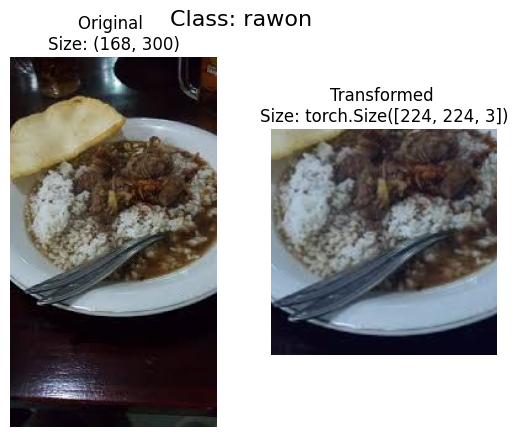

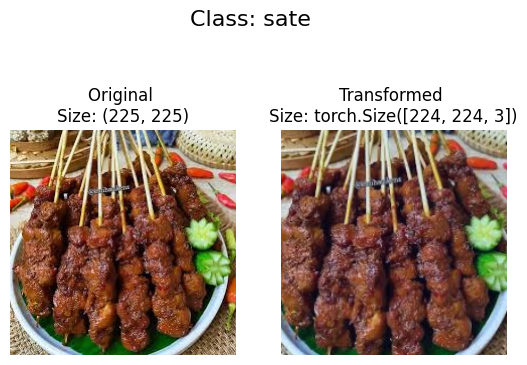

In [ ]:
torch.manual_seed(42)

image_path_list = list(image_paths.glob("*/*/*.jpg"))

random_image_paths = random.sample(image_path_list, k=2)
for image_path in random_image_paths:
    with Image.open(image_path) as f:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(f)
        ax[0].set_title(f"Original \nSize: {f.size}")
        ax[0].axis("off")

        # Transform and plot image
        # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
        transformed_image = vit2_transforms(f).permute(1, 2, 0)

        # Normalize the transformed image data for plotting
        # We'll scale it to the 0-1 range for plotting
        transformed_image = (transformed_image - transformed_image.min()) / (transformed_image.max() - transformed_image.min())

        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
        ax[1].axis("off")

        fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

In [ ]:
# Create train and test datasets
train_data2 = datasets.ImageFolder(root=train_dir,
                                  transform=train_transforms,
                                  target_transform=None)

test_data2 = datasets.ImageFolder(root=test_dir,
                                 transform=vit2_transforms,
                                 target_transform=None)
print(f"Train data:\n{train_data2}")
print(f"Test data:\n{test_data2}")

Train data:
Dataset ImageFolder
    Number of datapoints: 2866
    Root location: data/indonesian_food_image/train
    StandardTransform
Transform: Compose(
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 1193
    Root location: data/indonesian_food_image/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )


In [ ]:
# Create DataLoader
BATCH_SIZE = 32;
NUM_WORKERS = os.cpu_count()

train_dataloader2 = DataLoader(train_data2,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader2 = DataLoader(test_data2,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

print(f"Train DataLoader: {len(train_dataloader2)} batches of batch size {BATCH_SIZE}")
print(f"Test DataLoader: {len(test_dataloader2)} batches of batch size {BATCH_SIZE}")

Train DataLoader: 90 batches of batch size 32
Test DataLoader: 38 batches of batch size 32


In [ ]:
vit2_model = torchvision.models.vit_b_16(weights=vit2_weights)
vit2_model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
# Freeze all layers in the model, and modify the classifier
torch.manual_seed(42)

for param in vit2_model.parameters():
    param.requires_grad = False

vit2_model.heads = nn.Sequential(
    nn.Linear(in_features=768,  # Keep it the same as the original model
              out_features=len(class_names) # Modify to our the number of our class_names
              ))

vit2_model.heads

Sequential(
  (0): Linear(in_features=768, out_features=10, bias=True)
)

In [ ]:
# Set up loss function and optimizer
loss_fn2 = torch.nn.CrossEntropyLoss()

optimizer2 = torch.optim.Adam(params=vit2_model.parameters(),
                              lr=0.001)

In [ ]:
# Start the training
torch.manual_seed(42)
NUM_EPOCHS = 20

start_time = timer()
vit2_model_results = train(model=vit2_model,
                        train_dataloader=train_dataloader2,
                        test_dataloader=test_dataloader2,
                        loss_fn=loss_fn2,
                        accuracy_fn=accuracy_fn,
                        optimizer=optimizer2,
                        epochs=NUM_EPOCHS,
                        device=device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 1.38004 | train_acc: 59.39% | test_loss: 0.85393 | test_acc: 75.77%
Epoch: 1 | train_loss: 0.85323 | train_acc: 75.88% | test_loss: 0.65114 | test_acc: 81.50%
Epoch: 2 | train_loss: 0.71494 | train_acc: 78.55% | test_loss: 0.56712 | test_acc: 83.79%
Epoch: 3 | train_loss: 0.63715 | train_acc: 81.46% | test_loss: 0.51213 | test_acc: 85.53%
Epoch: 4 | train_loss: 0.58314 | train_acc: 82.08% | test_loss: 0.47306 | test_acc: 85.85%
Epoch: 5 | train_loss: 0.54625 | train_acc: 83.71% | test_loss: 0.45746 | test_acc: 86.09%
Epoch: 6 | train_loss: 0.50705 | train_acc: 85.43% | test_loss: 0.43623 | test_acc: 87.20%
Epoch: 7 | train_loss: 0.50905 | train_acc: 84.44% | test_loss: 0.42511 | test_acc: 87.16%
Epoch: 8 | train_loss: 0.46878 | train_acc: 86.66% | test_loss: 0.40769 | test_acc: 87.16%
Epoch: 9 | train_loss: 0.44196 | train_acc: 87.14% | test_loss: 0.39566 | test_acc: 88.19%
Epoch: 10 | train_loss: 0.45029 | train_acc: 86.65% | test_loss: 0.38048 | test_acc: 88.36

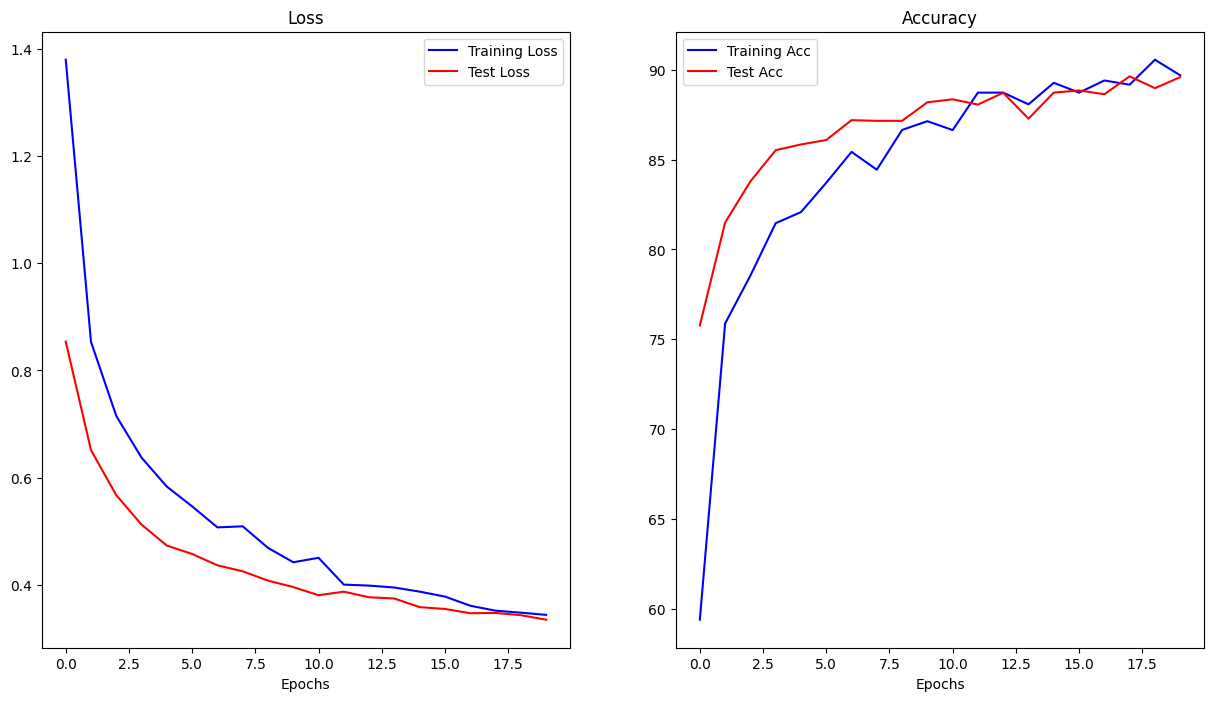

In [ ]:
plot_loss_acc(vit2_model_results)

In [ ]:
MODEL_SAVE_PATH = "vit2_model_89_percent.pth"
print(f"Saving model checkpoint to: {MODEL_SAVE_PATH}")
torch.save(vit2_model.state_dict(), MODEL_SAVE_PATH)

Saving model checkpoint to: vit2_model_89_percent.pth


The accuracy and loss plot seems a lot better! How about we train longer?

In [ ]:
# Second training
torch.manual_seed(42)
NUM_EPOCHS = 10

start_time = timer()
vit2_model_results_2 = train(model=vit2_model,
                        train_dataloader=train_dataloader2,
                        test_dataloader=test_dataloader2,
                        loss_fn=loss_fn2,
                        accuracy_fn=accuracy_fn,
                        optimizer=optimizer2,
                        epochs=NUM_EPOCHS,
                        device=device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 0.33151 | train_acc: 90.88% | test_loss: 0.34270 | test_acc: 88.85%
Epoch: 1 | train_loss: 0.33144 | train_acc: 90.47% | test_loss: 0.33773 | test_acc: 88.77%
Epoch: 2 | train_loss: 0.32094 | train_acc: 90.88% | test_loss: 0.34118 | test_acc: 88.02%
Epoch: 3 | train_loss: 0.31393 | train_acc: 90.91% | test_loss: 0.32653 | test_acc: 89.51%
Epoch: 4 | train_loss: 0.30627 | train_acc: 91.70% | test_loss: 0.31932 | test_acc: 89.14%
Epoch: 5 | train_loss: 0.30697 | train_acc: 91.33% | test_loss: 0.32477 | test_acc: 89.59%
Epoch: 6 | train_loss: 0.28882 | train_acc: 92.38% | test_loss: 0.32049 | test_acc: 89.55%
Epoch: 7 | train_loss: 0.32266 | train_acc: 91.02% | test_loss: 0.33132 | test_acc: 89.22%
Epoch: 8 | train_loss: 0.29612 | train_acc: 91.43% | test_loss: 0.32486 | test_acc: 89.14%
Epoch: 9 | train_loss: 0.28862 | train_acc: 91.95% | test_loss: 0.31981 | test_acc: 88.81%
Total training time: 412.597 seconds


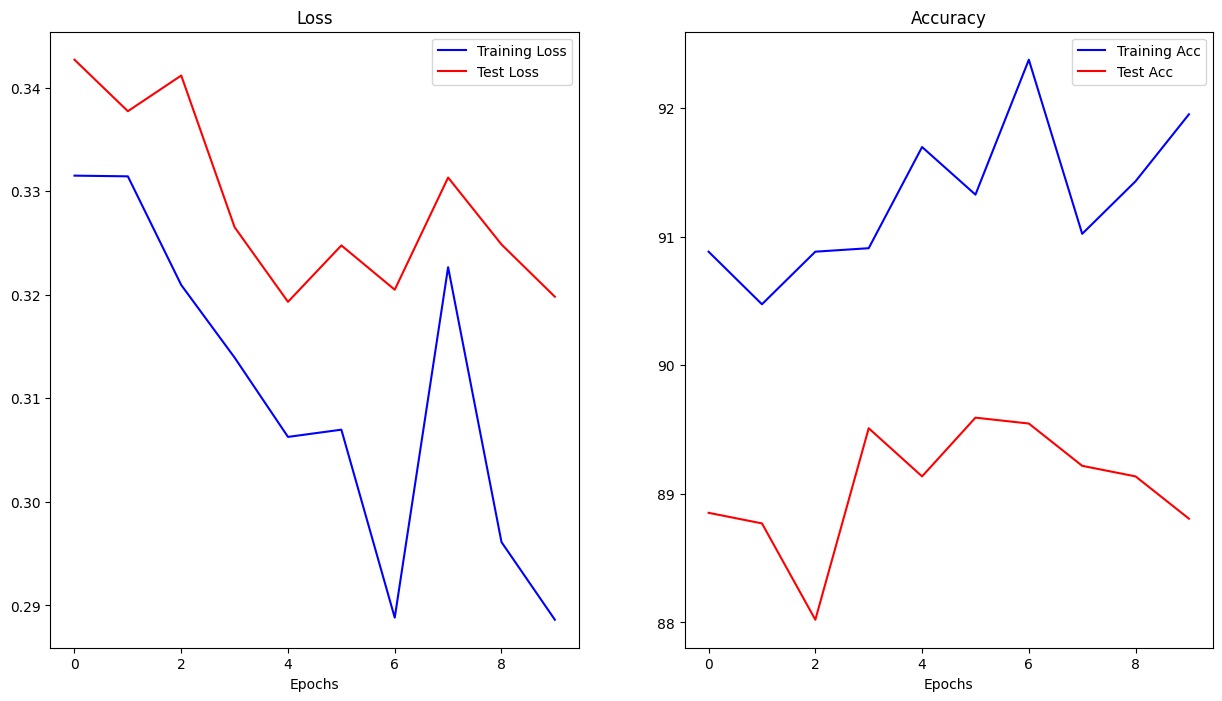

In [ ]:
plot_loss_acc(vit2_model_results_2)

Okay, it looks like the model overfit after training longer, so we will keep our previous model.

## 4. Model Inference

### 4.1 Load Saved Model

In [ ]:
# Load the saved model
loaded_vit2_model = torchvision.models.vit_b_16(weights=vit2_weights)

# Freeze all layers in the loaded model, and modify the classifier
for param in loaded_vit2_model.parameters():
    param.requires_grad = False

loaded_vit2_model.heads = nn.Sequential(
    nn.Linear(in_features=768,
              out_features=len(class_names)
              ))

# Load the state dictionary
loaded_vit2_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Move the model to the device
loaded_vit2_model.to(device)

print(f"Loaded model state dict from {MODEL_SAVE_PATH}")

Loaded model state dict from vit2_model_89_percent.pth


In [ ]:
# loaded_vit2_model

### 4.2 Setup Custom Image

In [ ]:
custom_image_path = data_path / "pempek.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/reygen-win/Machine-Learning/main/Classification/4_Indonesia%20Food%20Image%20Classification/indonesia_food_image/pempek.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [ ]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image shape: torch.Size([3, 800, 800])

Custom image dtype: torch.float32


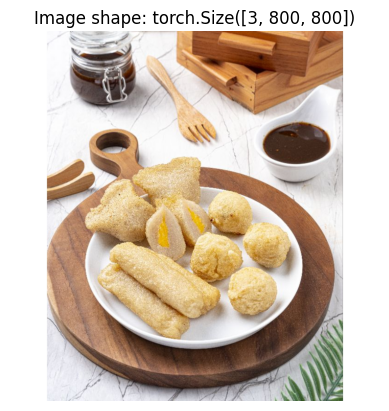

In [ ]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [ ]:
# Define transform for custom image (just like test dataset)
custom_image_transform = torchvision.models.ViT_B_16_Weights.DEFAULT.transforms()

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 800, 800])
New shape: torch.Size([3, 224, 224])


### 4.3 Inference

In [ ]:
loaded_vit2_model.eval()
with torch.inference_mode():
    # Make a prediction on image with an extra dimension
    custom_image_pred = loaded_vit2_model(custom_image_transformed.unsqueeze(dim=0).to(device))

In [ ]:
custom_image_pred

tensor([[-0.8953, -1.3937, -3.8028, -3.0034, -3.7247, 10.1915,  0.1636, -2.8889,
          0.1714, -2.6600]], device='cuda:0')

In [ ]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")
print(f"Prediction class: {class_names[custom_image_pred_label]}")

Prediction logits: tensor([[-0.8953, -1.3937, -3.8028, -3.0034, -3.7247, 10.1915,  0.1636, -2.8889,
          0.1714, -2.6600]], device='cuda:0')
Prediction probabilities: tensor([[1.5310e-05, 9.3012e-06, 8.3614e-07, 1.8597e-06, 9.0409e-07, 9.9988e-01,
         4.4143e-05, 2.0855e-06, 4.4487e-05, 2.6217e-06]], device='cuda:0')
Prediction label: tensor([5], device='cuda:0')
Prediction class: pempek


Plot saved as submission.jpg


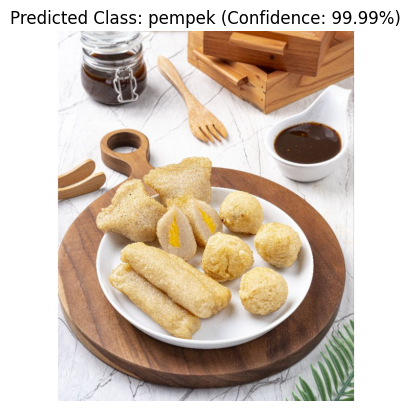

In [ ]:
# Plot the image alongside the prediction and prediction probability
plt.imshow(custom_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
if class_names:
    title = f"Predicted Class: {class_names[custom_image_pred_label]} (Confidence: {custom_image_pred_probs.max()*100:.2f}%)"

plt.title(title)
plt.axis(False)
plt.savefig('./submission.jpg')
print("Plot saved as submission.jpg")

Our model successfully predicted the "Pempek" food with confidence level of 99.99%

**Next step question**: Is the model very good? Or is it overfitting?

## 5. Model Deployment

### 5.1 Setup Folder

In [ ]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
indonesian_food_img_classification = Path("/content/indonesian_food_img_classification/")

# Remove files that might already exist there and create new directory
if indonesian_food_img_classification.exists():
    shutil.rmtree(indonesian_food_img_classification)

# If the file doesn't exist, create it anyway
indonesian_food_img_classification.mkdir(parents=True, exist_ok=True)

# Check what's in the folder
!ls indonesian_food_img_classification/

In [ ]:
# 1. Create an examples directory
indonesian_food_examples_path = indonesian_food_img_classification / "examples"
indonesian_food_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
indonesian_food_examples = [Path('data/indonesian_food_image/test/bakso/pic_026.jpg'),
                            Path('data/indonesian_food_image/test/gado_gado/pic_018.jpg'),
                            Path('data/indonesian_food_image/test/nasi_goreng/nasi_goreng_008.jpg')]

# 3. Copy the three random images to the examples directory
for example in indonesian_food_examples:
    destination = indonesian_food_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/indonesian_food_image/test/bakso/pic_026.jpg to /content/indonesian_food_img_classification/examples/pic_026.jpg
[INFO] Copying data/indonesian_food_image/test/gado_gado/pic_018.jpg to /content/indonesian_food_img_classification/examples/pic_018.jpg
[INFO] Copying data/indonesian_food_image/test/nasi_goreng/nasi_goreng_008.jpg to /content/indonesian_food_img_classification/examples/nasi_goreng_008.jpg


In [ ]:
# Create a source path for our target model
vit_model_path = "./vit2_model_89_percent.pth"

# Create a destination path for our target model
vit_model_destination = indonesian_food_img_classification / vit_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {vit_model_path} to {vit_model_destination}")

    # Move the model
    shutil.move(src=vit_model_path,
                dst=vit_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {vit_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {vit_model_destination}: {vit_model_destination.exists()}")

[INFO] Attempting to move ./vit2_model_89_percent.pth to /content/indonesian_food_img_classification/vit2_model_89_percent.pth
[INFO] Model move complete.


### 5.2 Write Python Script for Gradio UI

In [ ]:
%%writefile indonesian_food_img_classification/model.py
import torch
import torchvision

from torch import nn


def create_vit_model(num_classes:int=10,
                     seed:int=42):
    """Creates an ViT-B16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. Defaults to 10.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768,  # Keep it the same as the original model
                                out_features=num_classes # Modify to our the number of our class_names
                                ))

    return model, transforms

Overwriting indonesian_food_img_classification/model.py


In [ ]:
class_names

['bakso',
 'bebek_betutu',
 'gado_gado',
 'gudeg',
 'nasi_goreng',
 'pempek',
 'rawon',
 'rendang',
 'sate',
 'soto']

In [ ]:
%%writefile indonesian_food_img_classification/app.py

### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_vit_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['bakso',
               'bebek_betutu',
               'gado_gado',
               'gudeg',
               'nasi_goreng',
               'pempek',
               'rawon',
               'rendang',
               'sate',
               'soto']

### 2. Model and transforms preparation ###
# Create ViT-B16 model
vit_model, vit_transforms = create_vit_model(num_classes=len(class_names))

# Load saved weights
vit_model.load_state_dict(
    torch.load(
        f="vit2_model_89_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    start_time = timer()

    img = vit_transforms(img).unsqueeze(0)

    vit_model.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(vit_model(img), dim=1)

    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    pred_time = round(timer() - start_time, 5)

    return pred_labels_and_probs, pred_time

### 4. Gradio app ###
# Create title, description and article strings
title = "Indonesian Food Image Classification 🇮🇩"
description = "A ViT-B16 feature extractor computer vision model to classify images of Indonesian food."
article = "Created as part of a computer vision project."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

demo.launch()

Writing indonesian_food_img_classification/app.py


In [ ]:
torch.__version__

'2.8.0+cu126'

In [ ]:
torchvision.__version__

'0.23.0+cu126'

In [ ]:
import gradio as gr
gr.__version__

'5.49.1'

In [ ]:
%%writefile indonesian_food_img_classification/requirements.txt
torch==2.8.0
torchvision==0.23.0
gradio==5.49.1

Writing indonesian_food_img_classification/requirements.txt


In [ ]:
!ls indonesian_food_img_classification/

app.py	examples  model.py  requirements.txt  vit2_model_89_percent.pth


### 5.3 Download the Zip Files of the Folder Setup

In [ ]:
!cd indonesian_food_img_classification/ && zip -r ../indonesian_food_img_classification.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

try:
    from google.colab import files
    files.download("./indonesian_food_img_classification.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

updating: app.py (deflated 56%)
updating: examples/ (stored 0%)
updating: examples/pic_026.jpg (deflated 1%)
updating: examples/pic_018.jpg (deflated 0%)
updating: examples/nasi_goreng_008.jpg (deflated 0%)
updating: model.py (deflated 56%)
updating: requirements.txt (deflated 4%)
updating: vit2_model_89_percent.pth (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 5.4 Hugging-Face Demo

[Indonesian Food Image Classification by Reygen Win](https://huggingface.co/spaces/reygen-win/Indonesian_Food_Image_Classification)